# Demo 1. Overview of AutoMIND workflow for mechanistic circuit model parameter discovery

In this first demo, we will walk through the most direct use case of AutoMIND: 
Given a target observation (perhaps an observation from your own dataset), we would like to use a pre-trained deep generative model (DGM) to discover spiking network model parameter configurations which are consistent with that observation.

In particular, we target the power spectral density (PSD) of the population firing rate, a 990-dimensional observation, to demonstrate the capabilities of AutoMIND in this example.

We will then simulate and analyze a few of those discovered model configurations to check if they indeed reproduce the target observation.

For more details, visit the [AutoMIND preprint](https://www.biorxiv.org/content/10.1101/2024.08.21.608969v1).

---
Note: to run this notebook live, you will first need to download and unzip the trained DGMs and example dataset. You can find them from the data repository links on the [homepage](https://github.com/mackelab/automind), and you should place them in the appropriate directories by following the included instructions (or simply change the datapaths below).

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
mpl_rc = '../assets/matplotlibrc'
plt.style.use(mpl_rc)

import numpy as np
import pandas as pd
from torch import Tensor
from time import time

from automind.sim import b2_interface, runners
from automind.inference import inferer, handler
from automind.utils import data_utils, dist_utils, plot_utils

---
# Load trained DGM, meta info, and dataset
First, we load the trained deep generative model (Normalizing Flow) stored in the `posterior.pickle` file, along with some analysis parameters we need in `params_dict_analysis_updated.pickle`.

As its name suggests, the posterior file contains the trained posterior estimator neural network, constructed using the `sbi` package. The one we use below is particular to the type of data feature we wish to target, i.e., high-dimensional PSDs. 

In addition, it contains some meta information, like the specific data features it was trained on (`freq_bounds`)---and hence must be passed during inference---as well as data preprocessing steps, which must also be applied to the target observation as well.

In [2]:
data_dirs = "../datasets/discovered/synthetic/"
path_dict = data_utils.extract_data_files(data_dirs, ['posterior.pickle', 'params_dict_analysis_updated.pickle', 'summary_data_merged.csv'])
df_xos, posterior, params_dict = data_utils.load_df_posteriors(path_dict)
_, _, _, _, cols_psd = data_utils.separate_feature_columns(df_xos)
print(posterior)

posterior.pickle ['7149324_posterior.pickle']
params_dict_analysis_updated.pickle ['7149324_MK1_params_dict_analysis_updated.pickle']
summary_data_merged.csv ['7149324_MK1_summary_data_merged.csv']
1003 samples per xo.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [3]:
f_bounds = posterior.x_bounds_and_transforms['freq_bounds']
print(f"Density estimator was trained on PSD between {f_bounds} Hz.")

# Extract the frequency bounds and trim correspondingly
freqs = data_utils.decode_df_float_axis(cols_psd)
f_idx = (freqs >= f_bounds[0]) & (freqs <= f_bounds[1])
freqs, cols_features = freqs[f_idx], np.array(cols_psd)[f_idx]

Density estimator was trained on PSD between (0.5, 495) Hz.


### Define target observation data
As for the observation, for convenience, we use a target observation from one of the synthetic datasets in the paper (i.e., a network simulation from the held-out test set not used for DGM training), which is in the file `MK1_summary_data_merged.csv`. 

The csv file actually includes a number of different summary features computed on this particular observation, but we will target specifically its population rate PSD as the summary feature we want to reproduce. 

We will just pick one with some interesting spectral features. Note the prominent (gamma) oscillation around 65Hz, and a smaller peak around 100Hz.

WARNING    /tmp/ipykernel_86779/1826912943.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


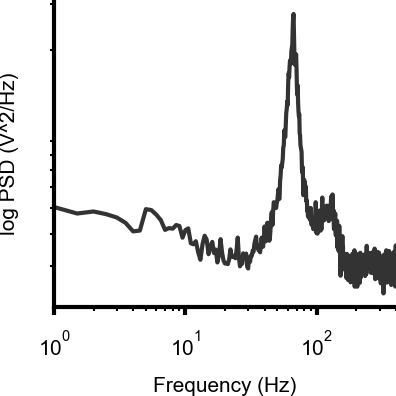

In [4]:
idx_xo = 10030
xo_raw = df_xos.loc[idx_xo][cols_features].values
plt.loglog(freqs, xo_raw, 'k', alpha=0.8); 
plt.xlabel('Frequency (Hz)'); plt.ylabel('log PSD (V^2/Hz)'); plt.yticks([]); plt.xlim([1,400])
plt.tight_layout()

### Data preprocessing
The target observation PSD has to undergo a few preprocessing steps, such as taking the log, normalizing, and re-scaling, etc. These transformations are tracked in the posterior network object (`posterior.x_bounds_and_transforms` and `posterior.x_standardizing_func`), and just need to be applied to the dataset. 

If you want to run this demo on a new dataset, you just need to replace `df_xos` with your own dataframe, where each row must contain, among other features, a PSD from 0.5 to 495Hz, at 0.5Hz frequency resolution. Alternatively, it can be supplied as a log10-PSD in a numpy array (`xo`), where only the last step is necessary (standardizing and converting to torch tensor).

In [5]:
df_xos_preproc, _, _, _ = dist_utils.preproc_dataframe_psd(df_xos.loc[[idx_xo]], posterior.x_bounds_and_transforms, drop_nans=False, replace_infs=True)
xo = df_xos_preproc.loc[idx_xo][cols_features].values
xo_tensor = posterior.x_standardizing_func(Tensor(xo[None,:]))
print(f"Target observation has shape {xo_tensor.shape}")


0 sims dropped due to early stopping.
0 sims dropped due to manual criteria.
0 sims dropped due to power threshold discard.
0 samples discarded in total.
Target observation has shape torch.Size([1, 990])


---
# Inference
This is where the magic happens: we provide the (preprocessed) target observation and draw samples of model configurations that are likely to reproduce this target.

Under the hood, the target is supplied as the conditioner to the conditional Normalizing Flow, which then approximates the posterior distribution given that observation, i.e., $p(parameters|target)$.

Also, we apply the "oversampling" trick here: to acquire `n_samples=5` samples in the end, we first sample by a factor of `oversample_factor=200` more (so 1000 total), and then select the top 5 samples with the highest log-likelihood returned by the Normalizing Flow. This is a fast and cheap operation and encourages samples to be in high-density regions, which empirically helps with finding better data-consistent samples.

In [6]:
# Set batch and random seeds
batch_seed = 20240823
data_utils.set_all_seeds(batch_seed)

n_samples = 5
cfg_sample = {
    "name": "demo_NPE",
    "oversample_factor": 200,
    "do_sample_map": False,
    "do_sample_pmean": False,
}
    
df_samples, samples_dict = inferer.sample_from_posterior(
            posterior = posterior, # Posterior network
            prior = posterior, # Need for extracting bounds
            num_samples = n_samples, # Number of samples to draw
            x_o = xo_tensor, # Target observation
            cfg_algorithm = cfg_sample, # Sampling options
        )

df_samples

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

WARNING    /home/rdgao/miniconda3/envs/automind_mini/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(
 [py.warnings]


,inference.type,infer.log_prob,params_net.exc_prop,params_net.p_e2e,params_net.p_e2i,params_net.p_i2e,params_net.p_i2i,params_net.R_pe2e,params_net.R_Qe2e,params_Epop.p_igniters,...,params_Epop.tau_w,params_Epop.E_gi,params_Epop.Q_ge,params_Epop.Q_gi,params_Epop.tau_ge,params_Epop.tau_gi,params_Epop.poisson_rate,params_Ipop.Q_ge,params_Ipop.Q_gi,params_Ipop.poisson_rate
0,demo_NPE_samples_prune_200,15.478238,0.781976,0.024205,0.046846,0.136437,0.163398,1.741674,1.363145,0.985056,...,11443.252930,-75.929283,3.060468,19.517969,15.427574,9.961973,4.555909,4.664642,9.066067,2.592393
1,demo_NPE_samples_prune_200,15.065972,0.887588,0.015302,0.068127,0.188009,0.159533,2.209649,1.148185,0.840746,...,14098.852539,-71.622292,3.000146,15.372008,16.391224,5.304996,4.893122,3.806506,18.270666,2.659153
2,demo_NPE_samples_prune_200,15.014516,0.822216,0.014814,0.047441,0.190952,0.138233,1.349009,1.857210,0.975408,...,6209.614746,-66.171951,2.846389,12.226171,13.769761,6.223661,4.216795,4.358890,19.230442,3.134106
3,demo_NPE_samples_prune_200,14.686677,0.839105,0.027946,0.044362,0.170837,0.160690,1.274470,1.924716,0.988818,...,13207.724609,-69.557861,1.817514,19.466232,16.811687,12.037863,4.515243,2.796453,11.720338,2.666300
4,demo_NPE_samples_prune_200,14.614991,0.889516,0.088333,0.055020,0.193097,0.173899,1.099473,1.821712,0.970462,...,7233.528320,-80.781227,1.527141,10.012551,15.281602,16.944878,4.904884,4.514221,9.945777,2.208319


### Visualize model parameters
What do these model configurations look like? 

We can plot their values for each of the 28 different parameters in the clustered-AdEx network, where just these 5 different models already span a large range of values for most of the parameters (each dot below is one of the above sampled configurations). In other words, they exhibit parameter degeneracy / invariance.

For details about the network model and what the parameters mean, see [here](https://www.biorxiv.org/content/10.1101/2024.08.21.608969v1.full.pdf#page=14.17).

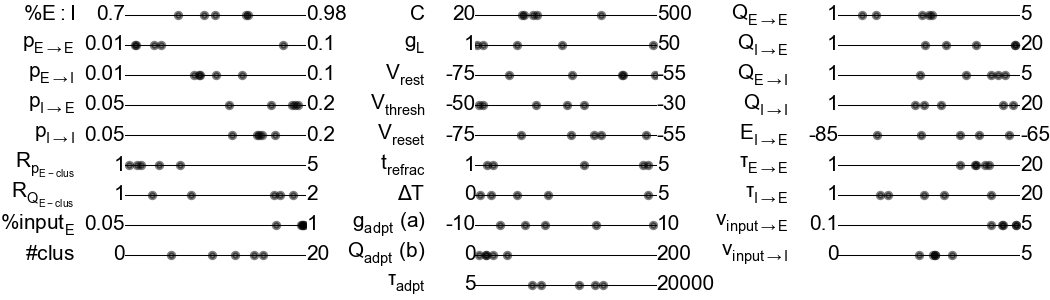

In [7]:
from automind.sim.default_configs import MKI_pretty_param_names
_, theta_minmax = dist_utils.standardize_theta(posterior.prior.sample((1,)), posterior)
fig, axs = plt.subplots(10, 3, figsize=(3.5,1))
plot_utils.plot_params_1D(df_samples[posterior.names].values, theta_minmax, MKI_pretty_param_names, (fig, axs), color='k', draw_canvas=True,
                                  draw_kde=False, draw_samples=True, labelpad=12, draw_median=False, sample_ms=3, sample_alpha=0.5);

---
# Simulate discovered configurations
Now, we can take those model parameter configurations and simulate them using the clustered AdEx spiking neural network, saving the spike train data and some meta-info.

For the purpose of the demo, we run the simulations in the notebook. However, this does take a long time, especially when multiprocessing doesn't place nice with Jupyter, i.e., as reported for Mac and Windows. Practically, this step is done on a compute cluster, and is highly parallelizeable (1 cpu per simulation). 

In [8]:
# Some housekeeping to set random seed identifiers and set up simulation configurations
# params_dict['params_settings']['batch_seed'] = batch_seed
random_seeds = np.sort(np.random.choice(a=int(n_samples * 100), size=n_samples, replace=False))
df_samples.insert(loc=0,column="params_settings.batch_seed",value=batch_seed)
df_samples.insert(loc=1,column="params_settings.random_seed",value=random_seeds)
params_dict_run = handler.fill_params_dict(params_dict, df_samples, posterior.as_dict, n_samples)

params_settings.batch_seed has no prior. Copied as bare value without unit.
params_settings.random_seed has no prior. Copied as bare value without unit.


In [9]:
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)

sim_parallel = True
if sim_parallel:
    from multiprocessing import Pool
    start_time = time()
    with Pool(n_samples) as pool:
        sim_collector = pool.map(runners.adex_simulator, params_dict_run)
    print(f"Simulations took {time()-start_time:.2f} seconds.")
else:
    sim_collector = []
    for i_sim in range(n_samples):
        start_time = time()        
        sim_collector.append(runners.adex_simulator(params_dict_run[i_sim]))
        print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")

b2_interface.clear_b2_cache(cache_path)

cache non-existent.
20240823-4020240823-15120240823-40720240823-47420240823-282|||||

cc1plus: warning: command-line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command-line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command-line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command-line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command-line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command-line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
cc1plus: warning: command-line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
In file included from ./.cache/_cython_magic_050b3a32e6728585e88daa4a987f2e40.cpp:47:
/home/rdgao/miniconda3/envs/automind_mini/include/python3.8/Python.h:44:10: fatal error: crypt.h: No such file or directory
   44 | #include <crypt.h>
      |          ^~~~~~~~~
compilation terminated.
WARNING    Cannot use Cython, a test com

Simulations took 347.59 seconds.
cache cleared: ./.cache/.


### Compute summary features
From the simulation data (spike trains), we can analyze them and extract a number of features, including smoothed population firing rate over time, network burst metrics, etc.

In [10]:
results_collector = [data_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector]

### Plot the discovered model simulations
Finally, we plot a 30 second segment of the simulated spike trains, as well as the population firing rate and power spectrum, of each discovered model.

WARNING    /home/rdgao/miniconda3/envs/automind_mini/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
 [py.warnings]
WARNING    /home/rdgao/miniconda3/envs/automind_mini/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


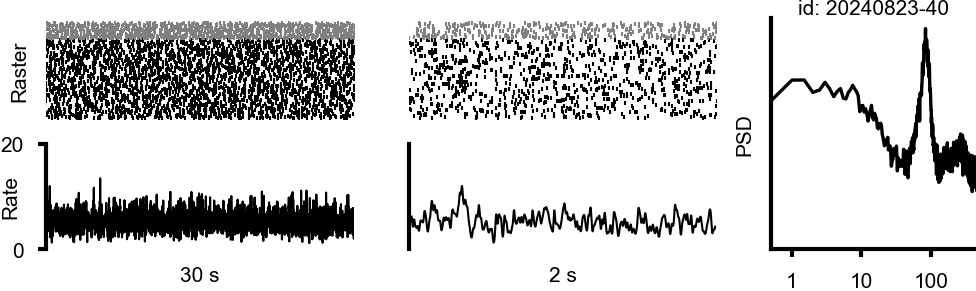

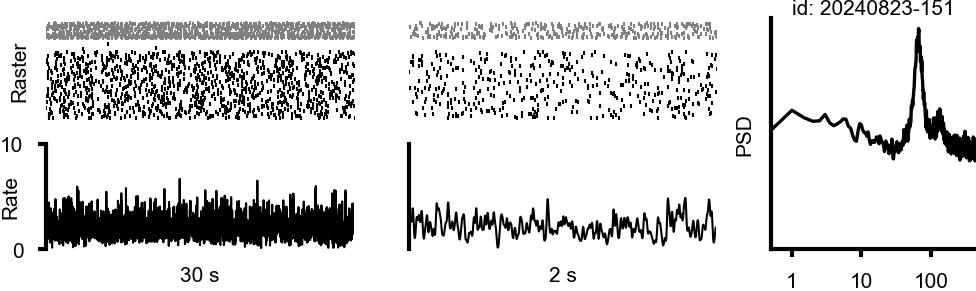

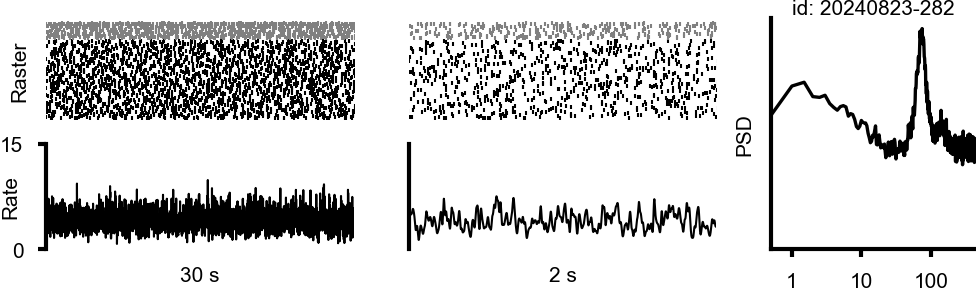

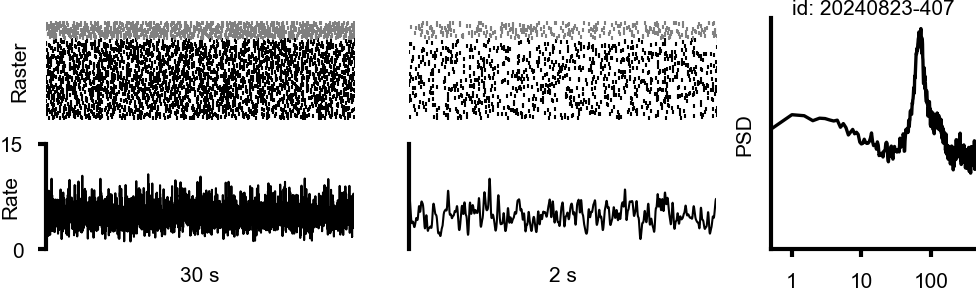

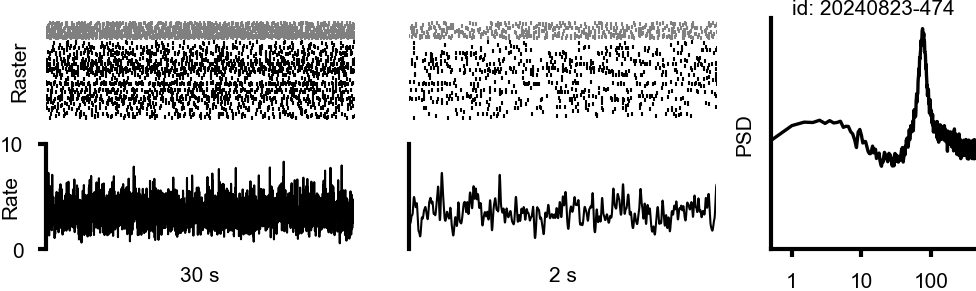

In [11]:
from matplotlib import gridspec
# Plot the results
xlims = [90,120]
xlims_zoom=[90,92]
every_other = 10
for i_sim, results in enumerate(results_collector):    
    fig = plt.figure(figsize=(4., 1.))
    
    gs = gridspec.GridSpec(2, 3, width_ratios=[1.5, 1.5, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[:, 2])
    
    # Plot raster, rates, and PSD
    plot_utils._plot_raster_pretty(sim_collector[i_sim][1], XL=xlims, every_other=every_other, fontsize=5, ax=ax1)
    plot_utils._plot_rates_pretty(results_collector[i_sim]['pop_rates'], XL=xlims, pops_to_plot=['avgpop_rate'], ylim_past=10*1000, fontsize=5, ax=ax2, color='k'); ax2.set_ylabel('Rate', labelpad=-5)
    
    plot_utils._plot_raster_pretty(sim_collector[i_sim][1], XL=xlims_zoom, every_other=2, fontsize=5, ax=ax3)
    plot_utils._plot_rates_pretty(results_collector[i_sim]['pop_rates'], XL=xlims_zoom, pops_to_plot=['avgpop_rate'], ylim_past=10*1000, fontsize=5, ax=ax4, color='k');    
    plot_utils._plot_psd_pretty(results_collector[i_sim]['summary_psd'], ['avgpop_rate'], ax5, fontsize=5); 
    ax2.set_ylabel('Rate', labelpad=-5); ax3.set_ylabel(''); ax4.set_ylabel(''); ax4.set_yticks([])
    ax5.set_title(f"id: {batch_seed}-{sim_collector[i_sim][0]['params_settings']['random_seed']}", pad=0)

### Not bad! 

The 5 discovered models closely reproduce the spectral characteristics of the target data, and we can see from both the raster and rate time series that they are in the low-firing regime with asynchronous oscillations. They look so similar, in fact, that one hardly believes that they are actually different models unless we zoom in to be able to see the minute differences in details.

We can plot all the spectra together after applying the same preprocessing and normalization steps. Colored lines are the discovered models above, and thick black line is the target observation.

WARNING    /tmp/ipykernel_86779/3428936458.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
 [py.warnings]


0 sims dropped due to manual criteria.
0 sims dropped due to power threshold discard.
0 samples discarded in total.


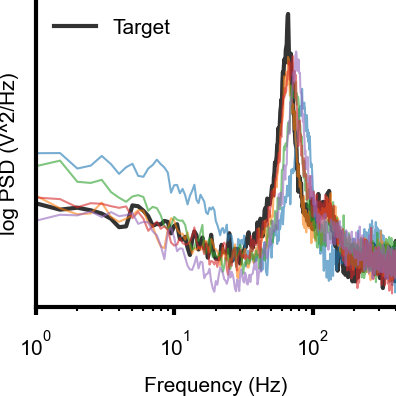

In [12]:
df_predictives = pd.concat([results['summary_psd'].loc[['avgpop_rate']] for results in results_collector])
x_predicitves = posterior.x_standardizing_func(
        Tensor(dist_utils.preproc_dataframe_psd(
            df_predictives, posterior.x_bounds_and_transforms, drop_nans=False, replace_infs=True)[0][cols_features].values
            )
)
plt.plot(freqs, xo_tensor.numpy().T, label='Target', alpha=0.8, zorder=0)
plt.plot(freqs, x_predicitves.numpy().T, alpha=0.6, lw=0.5)
plt.xscale('log'); plt.legend()
plt.xlabel('Frequency (Hz)'); plt.ylabel('log PSD (V^2/Hz)'); plt.yticks([]); plt.xlim([1,400])
plt.tight_layout()

---
# That's all for now.
Hopefully you got an overview of the workflow, key processing steps, and general capabilities of AutoMIND. 

We emphasize here again that, in a single Jupyter Notebook cell above, we could literally acquire hundreds or even thousands of **different** model configurations consistent with the **same** target observation here. Doing so for a different target observation simply requires loading a different data vector. This is the power of deep generative models combined with an interpretable mechanistic circuit model.

In the following demos, we will explore how to train a posterior network from scratch, and using different data features.